# TensorFlow low level APIs

To build our model we need to do a few steps:
- Download the MNIST dataset with consist of labeled handwritten images (28x28 px).
- Identify the feature that we are going to train the model on, which are just our image pixels.
- And let us use neural networks to build our model (LeNet-5 network architecture).
- The final step would to train our model and then test and validate how well we did.


## 1. Download MNIST dataset

Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [0]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [0]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Load the data

Load train and test data in memory

In [0]:
# Update libraries
!pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 24.5MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [0]:
import gzip
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [0]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [0]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


#### Display some images

In [0]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

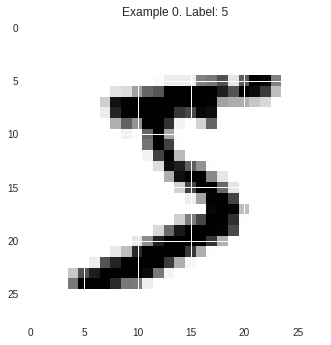

In [0]:
display_image(0)

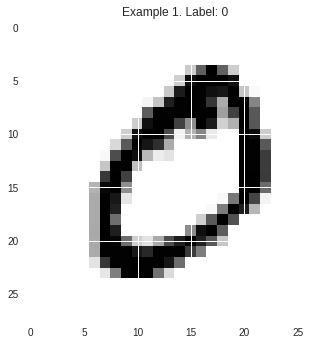

In [0]:
display_image(1)

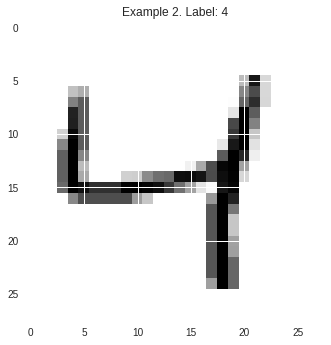

In [0]:
display_image(2)

#### Plot training data

In [0]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Count,Label
0,5923,0
1,6742,1
2,5958,2
3,6131,3
4,5842,4
5,5421,5
6,5918,6
7,6265,7
8,5851,8
9,5949,9


In [0]:
# sns.catplot(x="Label", y="Count",
#             kind="bar",
#             data=dataframe_train_labels)

### Suffle and split training data into training and validation

Shuffling and splitting our training data into 2 sets: train and validation. While leaving the test data unseen by our model untill we are done with the training to avoid a self-fulfilling prophecy. 

Once we have a trained model, we check our test data to check how accurate our model is.


In [0]:
train['features'], train['labels'] = shuffle(train['features'], train['labels'])

In [0]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [0]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## 2. Prepare our input features

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [0]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


Set `EPOCH` and `BATCH_SIZE` hyperparameter values which would affect the training speed and model accuracy.

In [0]:
EPOCHS = 10
BATCH_SIZE = 128

## 3. LeNet-5 implmentation

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)



**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


In [0]:
from tensorflow.contrib.layers import flatten

n_classes = 10

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    
    weights = {
        # The shape of the filter weight is (height, width, input_depth, output_depth)
        'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
        'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
        'fl1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 16, 120), mean = mu, stddev = sigma)),
        'fl2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    }

    biases = {
        # The shape of the filter bias is (output_depth,)
        'conv1': tf.Variable(tf.zeros(6)),
        'conv2': tf.Variable(tf.zeros(16)),
        'fl1': tf.Variable(tf.zeros(120)),
        'fl2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['conv1'])
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['conv2'])
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fl0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fl1 = tf.add(tf.matmul(fl0, weights['fl1']), biases['fl1'])
    # Activation.
    fl1 = tf.nn.relu(fl1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fl2 = tf.add(tf.matmul(fl1, weights['fl2']), biases['fl2'])
    # Activation.
    fl2 = tf.nn.relu(fl2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fl2, weights['out']), biases['out'])
                 
    return logits

## 4. Training Pipeline


### Features and Labels

`x` is a placeholder for a batch of input images.

`y` is a placeholder for a batch of output labels.

In [0]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [0]:
learning_rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Model Evaluation

Evaluate how well the loss and accuracy of the model are


In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

### Train the Model

Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


In [0]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_examples = len(train['features'])
    
    print("Training LeNet...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(train['features'], train['labels'])
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(validation['features'], validation['labels'])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    train_file_writer = tf.summary.FileWriter('logs', session.graph)
    train_file_writer.close()
    
    saver.save(session, './lenet')
    print("Model saved")

Training LeNet...

EPOCH 1 ...
Validation Accuracy = 0.973

EPOCH 2 ...
Validation Accuracy = 0.983

EPOCH 3 ...
Validation Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.985

EPOCH 5 ...
Validation Accuracy = 0.980

EPOCH 6 ...
Validation Accuracy = 0.987

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.986

Model saved


## Evaluate the Model

Evaluate the performance of the model on the test set

In [0]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test['features'], test['labels'])
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.986


## Visualize the Model

Use `TensorBoard` to visualize the trained model and `ngrok` to access it

In [0]:
!ls -la

total 12168
drwxr-xr-x 1 root root    4096 Nov 26 08:35 .
drwxr-xr-x 1 root root    4096 Nov 26 08:33 ..
-rw-r--r-- 1 root root      67 Nov 26 08:35 checkpoint
drwxr-xr-x 4 root root    4096 Nov 20 18:06 .config
-rw-r--r-- 1 root root  740480 Nov 26 08:35 lenet.data-00000-of-00001
-rw-r--r-- 1 root root    1056 Nov 26 08:35 lenet.index
-rw-r--r-- 1 root root   80022 Nov 26 08:35 lenet.meta
drwxr-xr-x 2 root root    4096 Nov 26 08:35 logs
drwxr-xr-x 2 root root    4096 Nov 20 18:17 sample_data
-rw-r--r-- 1 root root 1648877 Nov 26 08:34 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    4542 Nov 26 08:34 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9912422 Nov 26 08:34 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root   28881 Nov 26 08:34 train-labels-idx1-ubyte.gz


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

--2018-11-26 08:35:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.84.34, 52.71.139.107, 52.54.84.112, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.84.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.75MB/s    in 0.7s    

2018-11-26 08:35:31 (7.75 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
        
ngrok_url = ngrok_url[0].replace("'", '')
print(ngrok_url)

http://2edf9650.ngrok.io


In [0]:
from IPython.display import IFrame

IFrame(ngrok_url, width=700, height=900)